In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
'''
Trains a deep NN for choosing top-K beams
Note that you need to download the datasets and save them in the folder specified in this code.
'''

#Import modules
import os
import csv
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.models import model_from_json,Model
from tensorflow.keras.layers import Dense,concatenate
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta,Adam
from sklearn.model_selection import train_test_split
from model_handler import ModelHandler

In [3]:
#Here you can choose a combination of sets of parameters to be used as the neural network input
coord = False  #coordinates with the receiver position obtained from GPS
img = False  #RGB images obtained from cameras
lidar = True  #three-dimensional histogram obtained from LIDAR point cloud

#Based on your choices above, make sure the datasets below can be found in the specific folders.
#If running on Colab, you may use /content/
COORDINATES_INPUT_FILE = "/content/drive/MyDrive/Colab Notebooks/IC/data/coord_input/coord_input.npz"
IMAGES_INPUT_FILE = "/content/drive/MyDrive/Colab Notebooks/IC/data/image_input/img_input_20.npz"
LIDAR_INPUT_FILE = "/content/drive/MyDrive/Colab Notebooks/IC/data/lidar_input/lidar_input.npz"
BEAM_OUTPUT_FILE = "/content/drive/MyDrive/Colab Notebooks/IC/data/beam_output/beams_output.npz"

In [4]:
###############################################################################
# Support functions
###############################################################################

#For description about top-k, including the explanation on how they treat ties (which can be misleading
#if your classifier is outputting a lot of ties (e.g. all 0's will lead to high top-k)
#https://www.tensorflow.org/api_docs/python/tf/nn/in_top_k

def top_10_accuracy(y_true,y_pred):
    return metrics.top_k_categorical_accuracy(y_true,y_pred,k=10)

def top_30_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=30)

def top_50_accuracy(y_true,y_pred):
    return metrics.top_k_categorical_accuracy(y_true,y_pred,k=50)

def top_100_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=100)


def sub2ind(array_shape, rows, cols):
    ind = rows*array_shape[1] + cols
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    return ind

def ind2sub(array_shape, ind):
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    rows = (ind.astype('int') / array_shape[1])
    cols = ind % array_shape[1]
    return (rows, cols)

def beamsLogScale(y,thresholdBelowMax):
        y_shape = y.shape
        
        for i in range(0,y_shape[0]):            
            thisOutputs = y[i,:]
            logOut = 20*np.log10(thisOutputs + 1e-30)
            minValue = np.amax(logOut) - thresholdBelowMax
            zeroedValueIndices = logOut < minValue
            thisOutputs[zeroedValueIndices]=0
            thisOutputs = thisOutputs / sum(thisOutputs)
            y[i,:] = thisOutputs
        
        return y

def getBeamOutput(output_file):
    
    thresholdBelowMax = 60
    
    yMatrix = output_cache_file['output_classification']
    
    yMatrix = np.abs(yMatrix)
    yMatrix /= np.max(yMatrix)
    yMatrixShape = yMatrix.shape
    num_classes = yMatrix.shape[1] * yMatrix.shape[2]
    
    y = yMatrix.reshape(yMatrix.shape[0],num_classes)
    y = beamsLogScale(y,thresholdBelowMax)
    
    return y,num_classes

In [5]:
###############################################################################
# Data configuration
###############################################################################
tf.device('/device:GPU:0') #in case you have a GPU

num_epochs = 160 #assume a rather small number just to demo things. You should try larger values
batch_size = 32 #mini-batch size
tgtRec = 3

seed = 7 #use a fixed number if you want to reproduce the same results
np.random.seed(seed)

In [6]:
#read the datasets with input parameters
if coord == True: 
    #train
    print("Reading dataset... ",COORDINATES_INPUT_FILE)
    coord_train_cache_file = np.load(COORDINATES_INPUT_FILE)
    X_coord = coord_train_cache_file['coordinates']
    X_coord_train, X_coord_validation = train_test_split(X_coord, test_size=0.2, random_state=seed, shuffle=True)

    coord_train_input_shape = X_coord_train.shape

if img == True:
    resizeFac = 20 # Resize Factor
    nCh = 1 # The number of channels of the image
    imgDim = (360,640) # Image dimensions
    method = 1

    #train
    print("Reading dataset... ",IMAGES_INPUT_FILE)
    img_train_cache_file = np.load(IMAGES_INPUT_FILE)
    X_img = img_train_cache_file['inputs']
    X_img_train, X_img_validation = train_test_split(X_img, test_size=0.2, random_state=seed, shuffle=True)

    img_train_input_shape = X_img_train.shape

if lidar == True:
    #train
    print("Reading dataset... ",LIDAR_INPUT_FILE)
    lidar_train_cache_file = np.load(LIDAR_INPUT_FILE)
    X_lidar = lidar_train_cache_file['input']
    X_lidar_train, X_lidar_validation = train_test_split(X_lidar, test_size=0.2, random_state=seed, shuffle=True)
    lidar_train_input_shape = X_lidar_train.shape

#read the dataset with output parameters
#train
print("Reading dataset...", BEAM_OUTPUT_FILE)
output_cache_file = np.load(BEAM_OUTPUT_FILE)
y_output,num_classes = getBeamOutput(output_cache_file)
y_train, y_validation = train_test_split(y_output, test_size=0.2, random_state=seed, shuffle=True)

Reading dataset...  /content/drive/MyDrive/Colab Notebooks/IC/data/lidar_input/lidar_input.npz
Reading dataset... /content/drive/MyDrive/Colab Notebooks/IC/data/beam_output/beams_output.npz


In [7]:
##############################################################################
# Model configuration
##############################################################################

#multimodal
multimodal = [coord, img, lidar]
plot = True # Active Plot output

#validationFraction = 0.2 #from 0 to 1
modelHand = ModelHandler()
opt = Adam()

if coord:
    coord_model = modelHand.createArchitecture('coord_mlp',num_classes,coord_train_input_shape[1],'complete')
if img:
    if nCh==1:   
        img_model = modelHand.createArchitecture('light_image',num_classes,[img_train_input_shape[1],img_train_input_shape[2],1],'complete')
    else:
        img_model = modelHand.createArchitecture('light_image',num_classes,[img_train_input_shape[1],img_train_input_shape[2],img_train_input_shape[3]],'complete')
if lidar:
    lidar_model = modelHand.createArchitecture('lidar_marcus',num_classes,[lidar_train_input_shape[1],lidar_train_input_shape[2],lidar_train_input_shape[3]],'complete')

if sum(multimodal) == 2:
    if coord and lidar:
        combined_model = concatenate([coord_model.output,lidar_model.output])
        z = Dense(num_classes,activation="relu")(combined_model)
        model = Model(inputs=[coord_model.input,lidar_model.input],outputs=z)
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit([X_coord_train,X_lidar_train],y_train, 
        validation_data=([X_coord_validation, X_lidar_validation], y_validation),epochs=num_epochs,batch_size=batch_size)

    elif coord and img:
        combined_model = concatenate([coord_model.output,img_model.output])
        z = Dense(num_classes,activation="relu")(combined_model)
        model = Model(inputs=[coord_model.input,img_model.input],outputs=z)
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit([X_coord_train,X_img_train],y_train,
        validation_data=([X_coord_validation, X_img_validation], y_validation), epochs=num_epochs,batch_size=batch_size)
    
    else:
        combined_model = concatenate([lidar_model.output,img_model.output])
        z = Dense(num_classes,activation="relu")(combined_model)
        model = Model(inputs=[lidar_model.input,img_model.input],outputs=z)
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit([X_lidar_train,X_img_train],y_train, 
        validation_data=([X_lidar_validation, X_img_validation], y_validation), epochs=num_epochs,batch_size=batch_size)
elif sum(multimodal) == 3:
    combined_model = concatenate([lidar_model.output,img_model.output, coord_model.output])
    z = Dense(num_classes,activation="relu")(combined_model)
    model = Model(inputs=[lidar_model.input,img_model.input, coord_model.input],outputs=z)
    model.compile(loss=categorical_crossentropy,
                optimizer=opt,
                metrics=[metrics.categorical_accuracy,
                        metrics.top_k_categorical_accuracy,
                        top_10_accuracy,
                        top_30_accuracy,
                        top_50_accuracy,
                        top_100_accuracy])
    model.summary()
    hist = model.fit([X_lidar_train,X_img_train,X_coord_train],y_train,
            validation_data=([X_lidar_validation, X_img_validation, X_coord_validation], y_validation),
            epochs=num_epochs,batch_size=batch_size)

else:
    if coord:
        model = coord_model
        model.compile(loss=categorical_crossentropy,
                            optimizer=opt,
                            metrics=[metrics.categorical_accuracy,
                                    metrics.top_k_categorical_accuracy,
                                    top_10_accuracy,
                                    top_30_accuracy, 
                                    top_50_accuracy,
                                    top_100_accuracy])
        model.summary()
        hist = model.fit(X_coord_train,y_train, 
        validation_data=(X_coord_validation, y_validation),epochs=num_epochs,batch_size=batch_size)

    elif img:
        model = img_model  
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit(X_img_train,y_train, 
        validation_data=(X_img_validation, y_validation),epochs=num_epochs,batch_size=batch_size)

    else:
        model = lidar_model
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit(X_lidar_train,y_train,epochs=num_epochs,batch_size=batch_size, validation_data=(X_lidar_validation, y_validation))

with open('history.txt', 'w') as f: 
       f.write(str(hist.history))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 200, 10)]     0         
                                                                 
 conv2d (Conv2D)             (None, 20, 200, 10)       16910     
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 200, 30)       36330     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 200, 25)       60775     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 200, 25)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 200, 25)       0         
                                                             

##Baselines cores

In [8]:
from scipy.special import softmax
beam_weights =  {}
for i in range(y_train.shape[1]):
	beam_weights[i] = 0

for i in range(y_train.shape[0]):
	scene_array = y_train[i,:]
	beam_weights[np.argmax(scene_array)] += 1

ocurrence = np.zeros((1,y_validation.shape[1]))
oc_factor = sum(beam_weights.values())
for b_index in beam_weights.keys():
	ocurrence[0,b_index] = beam_weights[b_index]/oc_factor
	
#ocurrence
ocurrence_input = np.repeat(ocurrence, y_validation.shape[0], axis=0)
ocurrence_output = softmax(ocurrence_input, axis=1)
#rand
rand_input = np.random.rand(2239,256)
rand_output = softmax(rand_input, axis=1)

#Accuracy / epochs

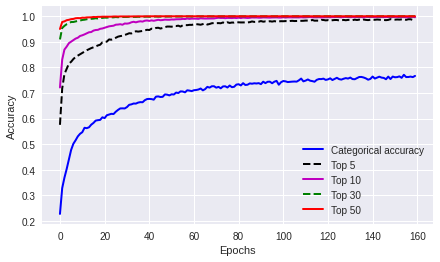

In [9]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(hist.history['categorical_accuracy'], 'b', label = 'Categorical accuracy', linewidth=2)
ax.plot(hist.history['top_k_categorical_accuracy'], 'k--', label = 'Top 5', linewidth=2)
ax.plot(hist.history['top_10_accuracy'], 'm', label = 'Top 10', linewidth=2)
ax.plot(hist.history['top_30_accuracy'], 'g--', label = 'Top 30', linewidth=2)
ax.plot(hist.history['top_50_accuracy'], 'r', label = 'Top 50', linewidth=2)
ax.set(xlabel='Epochs', ylabel='Accuracy')
#ax.grid()
plt.legend()
#plt.title('LIDAR data')
plt.show()

##Creating Baselines

In [10]:
from keras.metrics import top_k_categorical_accuracy
predict_top_k = {}
ocurrence_top_k = {}
random_top_k = {}
y_predict = model.predict(X_lidar_validation)
for i in range(1,51):
  predict_top_k[f'top_{i}'] = np.sum(top_k_categorical_accuracy(y_validation,y_predict,k = i))/y_predict.shape[0]
  ocurrence_top_k[f'top_{i}'] = np.sum(top_k_categorical_accuracy(y_validation,ocurrence_output,k = i))/y_predict.shape[0]
  random_top_k[f'top_{i}'] = np.sum(top_k_categorical_accuracy(y_validation,rand_output,k = i))/y_predict.shape[0]

## TOP 10 acurracy

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.46159, -0.36159, -0.26159, -0.16159, -0.06159,  0.03841,
         0.13841,  0.23841,  0.33841,  0.43841,  0.53841]),
 <a list of 10 Patch objects>)

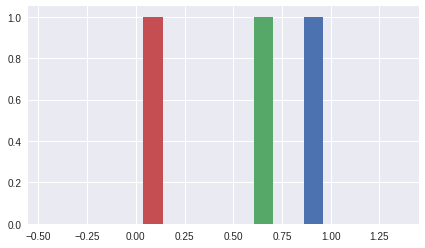

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 4))
plt.hist(predict_top_k['top_10'])
plt.hist(ocurrence_top_k['top_10'])
plt.hist(random_top_k['top_10'])

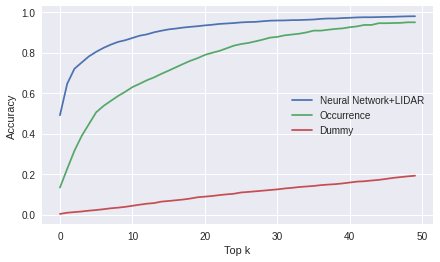

In [13]:
plt.figure(figsize=(7, 4))
plt.xlabel('Top k')
plt.ylabel('Accuracy')
plt.plot(list(predict_top_k.values()), label= 'Neural Network+LIDAR')
plt.plot(list(ocurrence_top_k.values()), label = 'Occurrence')
plt.plot(list(random_top_k.values()), label = 'Dummy')
#plt.grid()
plt.legend()